In [1]:
import librosa
import matplotlib.pyplot as plt
import neptune.new as neptune
import numpy as np
import pytorch_lightning as pl
import soundfile
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import build
from dct import isdct, sdct
from models import *
from mu_law import mu_decode, mu_encode

In [2]:
class DaNet(pl.LightningModule):
    def __init__(self, model_loader, noise=0.0, lr=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = eval(model_loader)
        self.lr = lr
        self.output_size = 2**12
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, aux = batch
        inp = F.pad(x, (1, -1)) + torch.randn_like(x) * self.hparams.noise
        x_hat = self.forward(inp)
        loss = F.cross_entropy(x_hat[-self.output_size:], x[-self.output_size:])
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = QHAdam(self.parameters(), lr=self.lr, nus=(0.7, 1.0))
        return {"optimizer": optimizer, "lr_scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5**0.001)}

In [20]:
project = neptune.init_project(name="mlxa/MusicBox", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NTIzY2UxZC1jMjI5LTRlYTQtYjQ0Yi1kM2JhMGU1NDllYTIifQ==")
project['middle1'].download('model.ckpt')
# premodel = MixtureNet(layers=2, blocks=2, res_channels=32, end_channels=32, classes=256, groups=16)
model = DaNet.load_from_checkpoint('model.ckpt')

Remember to stop your project once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/project#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [21]:
import build
loader = build.dataloader(data='dataset_v6', sample_length=2**13, part=0.1, batch_size=10, shuffle=True)
t, _ = next(iter(loader))
t = t[0][:, :1000]
t.shape

torch.Size([256, 1000])

In [22]:
def generate(model, iters, start):
    print('start')
    model.model.reset(show_progress=True)
    print('here')
    assert start.dim() == 2
    for i in tqdm(range(start.size(1) - 1), desc="Preparing"):
        model.model.generate(start[:, i])
    for _ in tqdm(range(iters), desc="Generating"):
        add = model.model.generate(start[:, -1]).unsqueeze(1)
        start = torch.cat([start, add], dim=1)
    return start

In [23]:
x = generate(model, 4096, start=t[:, :10])

start


Reset: 100%|██████████| 4096/4096 [04:02<00:00, 16.90it/s] 


here


Generating: 100%|██████████| 4096/4096 [04:07<00:00, 16.54it/s]


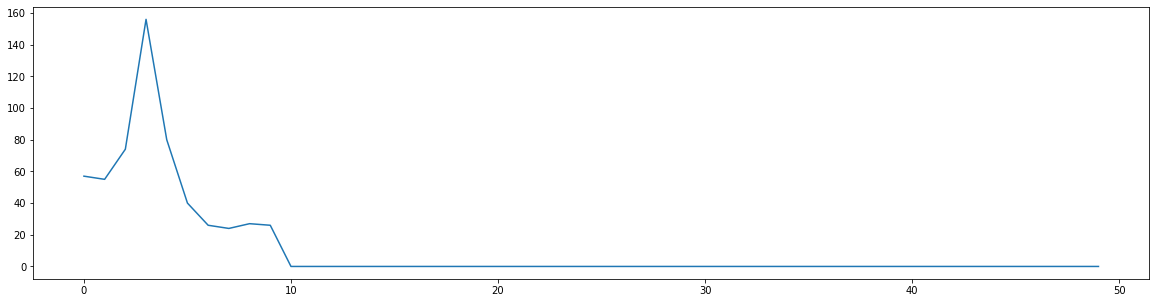

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(x[:, :50].argmax(dim=0))
# plt.plot(mu_decode((x[:, :500].argmax(dim=0) - 127.5) / 256))
plt.show()

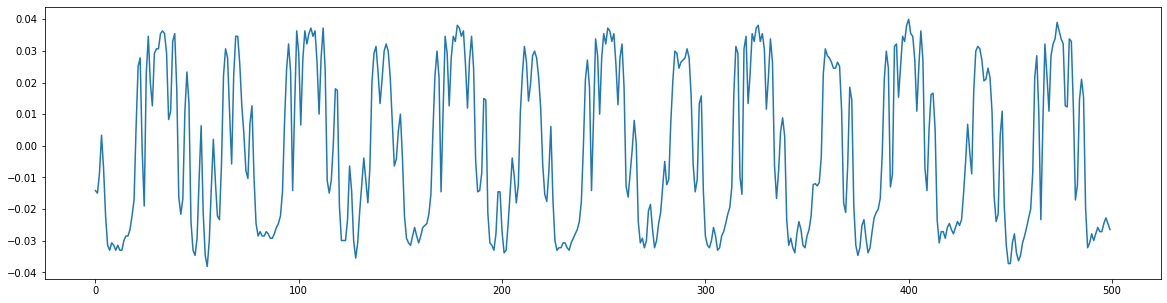

In [31]:
plt.figure(figsize=(20, 5))
# plt.plot((t[:, :500].argmax(dim=0) - 127.5) / 256)
plt.plot(mu_decode((t[:, :500].argmax(dim=0) - 127.5) / 256))
# plt.show()

In [26]:
soundfile.write('check.wav', mu_decode((x.argmax(dim=0) - 127.5) / 256).numpy(), samplerate=22050)

tensor(41) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


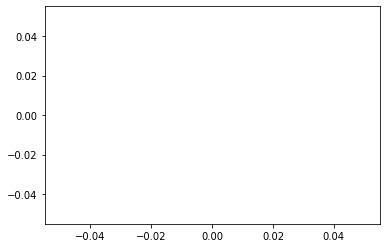

###
tensor(68) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


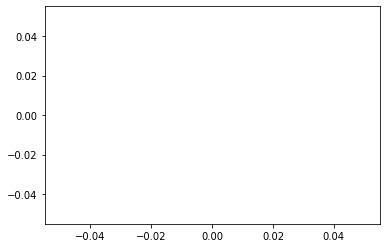

###
tensor(189) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


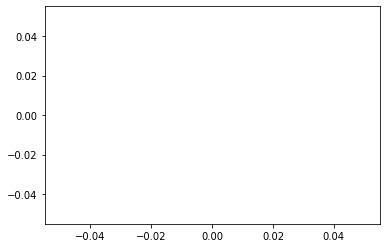

###
tensor(176) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


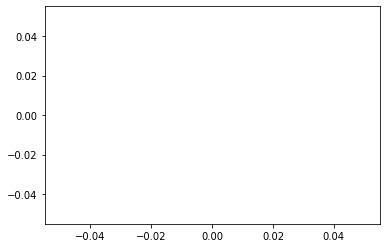

###
tensor(51) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


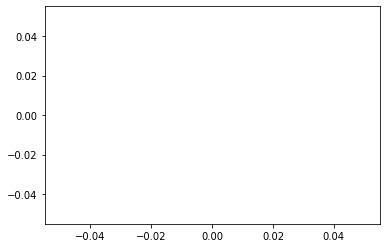

###
tensor(71) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


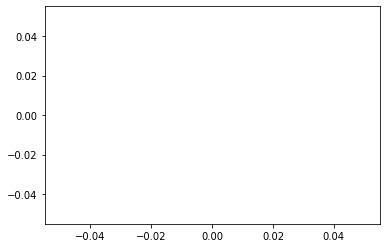

###
tensor(217) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


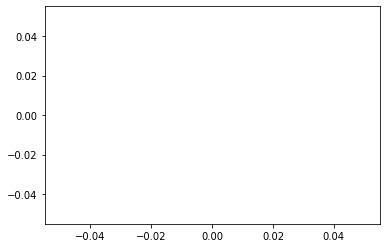

###
tensor(230) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


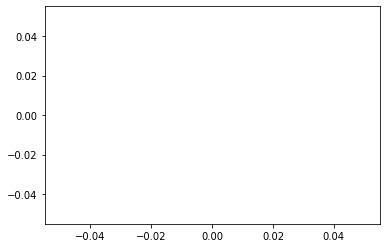

###
tensor(234) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


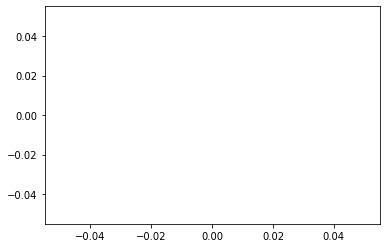

###
tensor(233) nan nan nan nan
tensor(0) nan nan tensor(nan) tensor(nan) tensor(nan)


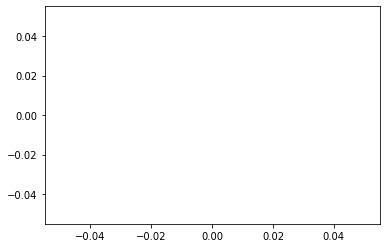

###


In [27]:
buffer = t[:, :500]
for i in range(10):
    buffer = torch.cat((buffer, torch.zeros((256, 1))), dim=1)
    predict = model(buffer.unsqueeze(0))[0, :, -1]
    prob = F.softmax(predict, dim=0).detach()
    nxt = t[:, 500 + i].argmax()
    idx = predict.argmax()
    print(nxt, predict[nxt].item(), prob[nxt].item(), predict.min().item(), predict.max().item())
    print(idx, predict[idx].item(), prob[idx].item(), prob.min(), prob.max(), prob.sum())
    plt.plot(predict.detach().numpy())
    plt.show()
    print('###')
    buffer[:, -1] = predict